In [1]:
import pandas as pd
import csv
import xml.etree.ElementTree as ET
import ast
import numpy as np
from string import ascii_lowercase
import sys
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
import matplotlib.mlab as mlab
from scipy.stats import norm
import os
from collections import defaultdict
import glob
from scipy.stats import norm
from __future__ import print_function

import numpy as np
from scipy.integrate import simps
from numpy import trapz

norm.cdf(1.96)

char_location_x = dict()
char_location_y = dict()
char_mean_x = dict()
char_sd_x = dict()
char_mean_y = dict()
char_sd_y = dict()

time_btwn_chars = dict()
mean_time_btwn_chars = dict()
sd_time_btwn_chars = dict()
mean_edit_distance, sd_edit_distance = 0.0, 0.0

x_y_coordinate = {'a': [63, 180],'b': [603, 345],
             'c': [387, 345],'d': [279, 180],
             'e': [225, 15],'f': [387, 180],
             'g': [495, 180],'h': [603, 180],
             'i': [765, 15],'j': [711, 180],
             'k': [819, 180],'l': [927, 180],
             'm': [819, 345],'n': [711, 345],
             'o': [873, 15],'p': [981, 15],
             'q': [117, 15],'r': [335, 15],
             's': [171, 180],'t': [441, 15],
             'u': [657, 15],'v': [495, 345],
             'w': [9, 15],'x': [279, 345],
             'y': [549, 15],'z': [171, 345]}

def initialize_globals():
    
    print('initializing globals from func')
    char_location_x = {}
    char_location_y = {}
    char_mean_x = {}
    char_sd_x = {}
    char_mean_y = {}
    char_sd_y = {}

    time_btwn_chars = {}
    mean_time_btwn_chars = {}
    sd_time_btwn_chars = {}
    mean_edit_distance, sd_edit_distance = 0.0, 0.0


def calculate_edit_distance(str1, str2, m, n):
    
    dp = [[0 for x in range(n+1)] for x in range(m+1)]
 
    for i in range(m+1):
        for j in range(n+1):

            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i][j-1],
                                   dp[i-1][j],
                                   dp[i-1][j-1])
 
    return dp[m][n]

# Assigns a score to a letter press depending on mean and sd values from training data
def bayesian_score(coordinate, char_mean, char_sd):
    
    if coordinate >= 1.0*(char_mean - 1.5*char_sd) and coordinate <= (char_mean + 1.5*char_sd):
        return 1.0
    elif coordinate >= (char_mean - 2.5*char_sd) and coordinate <= (char_mean + 2.5*char_sd):
        return 2.0/3.0
    elif coordinate >= (char_mean - 3.5*char_sd) and coordinate <= (char_mean + 3.5*char_sd):
        return 1.0/3.0
    return 0.0

def bayesian_score_coord(coordinate, char_mean, char_sd):
    
    if coordinate >= (char_mean - char_sd) and coordinate <= (char_mean + char_sd):
        return 1.0
    elif coordinate >= (char_mean - char_sd) and coordinate <= (char_mean + char_sd):
        return 2.0/3.0
    elif coordinate >= (char_mean - char_sd) and coordinate <= (char_mean + char_sd):
        return 1.0/3.0
    return 0.0

def calculate_force_score(force_mean,test_force_mean, force_sd, test_force_sd ):
 
    a = 1/(2*force_sd**2) - 1/(2*test_force_sd**2)
    b = test_force_mean/(test_force_sd**2) - force_mean/(force_sd**2)
    c = force_mean**2 /(2*force_sd**2) - test_force_mean**2 / (2*test_force_sd**2) - np.log(test_force_sd/force_sd)

    #Get point of intersect
    result = np.roots([a,b,c])

    #Get point on surface
    x = np.linspace(7,13,10000)
    plot1=plt.plot(x,norm.pdf(x,force_mean,force_sd))
    plot2=plt.plot(x,norm.pdf(x,test_force_mean,test_force_sd))
    plot3=plt.plot(result,norm.pdf(result,force_mean,force_sd),'o')

    #Plots integrated area
    r = result[0]
    olap = plt.fill_between(x[x>r], 0, norm.pdf(x[x>r],force_mean,force_sd),alpha=0.3)
    olap = plt.fill_between(x[x<r], 0, norm.pdf(x[x<r],test_force_mean,test_force_sd),alpha=0.3)
    plt.show()

    # integrate
    area = norm.cdf(r,test_force_mean,test_force_sd) + (1.-norm.cdf(r,force_mean,force_sd))
    print("Area under curves ", area)

    #Score calculation
    if area >=0.96 and area <= 1.1:
        return 1.0
    elif (area < 0.96 and area > 0.91) or (area > 1.1 and area < 1.15):
        return 1.0/2.0
    elif (area < 0.91 and area > 0.85) or (area > 1.15 and area < 1.25):
        return 1.0/4.0
    else:
        return 0.0


def score_word(word_x, word_y, word, char_mean_x, char_sd_x, char_mean_y, char_sd_y, phrase_x_score, phrase_y_score, test_phrase_x_vals, test_phrase_y_vals):

    #print('processing score for', prev_word)
    
    for x in word_x:
        test_phrase_x_vals.append(x)
    for y in word_y:
        test_phrase_y_vals.append(y)
    
    for i in range(len(word_x)):
        c_x = word_x[i]
        c_y = word_y[i]
                
        # ignore for now chars whose mean, sd not available due to missing train data
        if char_mean_x.get(word[i]) and char_sd_x.get(word[i]):
            phrase_x_score.append(bayesian_score_coord(c_x, char_mean_x[word[i]], char_sd_x[word[i]]))
            phrase_y_score.append(bayesian_score_coord(c_y, char_mean_y[word[i]], char_sd_y[word[i]]))
        else:
            print("training data missing for ", word[i])
            
def calculate_similarity(phrase_x_score, phrase_y_score, phrase_t_score, ed, force_score, prev_co):
    
    x_accuracy = (sum(phrase_x_score) * 1.0) / (len(phrase_x_score) * 1.0)
            
    y_accuracy = (sum(phrase_y_score) * 1.0) / (len(phrase_y_score) * 1.0)
            
    t_accuracy = (sum(phrase_t_score) * 1.0) / (len(phrase_t_score) * 1.0)
            
    ed_accuracy = (bayesian_score(ed, mean_edit_distance, sd_edit_distance)*1.0)
    
    accuracy = 10*x_accuracy + 10*y_accuracy + 40.0*t_accuracy + 10.0*ed_accuracy + 30.0*force_score
            
    print('ACCURACY of phrase -', prev_co, accuracy)
    print('x', x_accuracy, 'y', y_accuracy, 't', t_accuracy, 'ed', ed_accuracy, 'force', force_score)
    
    return accuracy

def calculate_user_typing_force(input_file):
    #Store the mean force and standard deviation in training_force
    
    in_txt = open(input_file,"r")
    file_string = in_txt.readlines()
        
    dataframe_list = [[]]
    
    #Process the file_string and store it in a list
    for line in file_string:
        line = line.replace('\n','')
        my_list = line.split(",")
        dataframe_list.append(my_list)
    
    #After processing store the file_string in a dataframe
    touch_point_dataframe_new = pd.DataFrame(dataframe_list)
    touch_point_dataframe_new.columns = ['InputFinger','UserID','KeyboardType','TaskType','BlockNum','TrialNum','Phrase',
           'curSysTime','upNowTime','eventTime','sensorType','value0',
           'value1','value2','isGestureExpert','Device','InputMode']
    touch_point_dataframe_new = touch_point_dataframe_new.drop(0) 
    touch_point_dataframe_new = touch_point_dataframe_new.drop(1)
    
    #Convert the feature value0, value1 and value2 as float and calculate the force
    touch_point_dataframe_new['value0'] = touch_point_dataframe_new['value0'].astype(float)
    touch_point_dataframe_new['value1'] = touch_point_dataframe_new['value1'].astype(float)
    touch_point_dataframe_new['value2'] = touch_point_dataframe_new['value2'].astype(float)
    touch_point_dataframe_new['totalforce'] = touch_point_dataframe_new.apply(lambda row: math.sqrt(row.value0**2 + row.value1**2 + row.value2**2), axis=1)
    
    #Separately calculate word forces and take their mean
    word  = touch_point_dataframe_new[touch_point_dataframe_new['totalforce']>1]
    forces = touch_point_dataframe_new['totalforce']
    total_force_mean = word.groupby('Phrase')['totalforce'].mean()
    word_mean = word['totalforce'].mean()
    word_std = word['totalforce'].std()
    
    return word_mean, word_std, forces

def train(train_path,test_path,train_sensor_path,test_sensor_path):
    
    initialize_globals()
    
    prev_x_coordinates, current_x_coordinates = [], []
    prev_y_coordinates, current_y_coordinates = [], []
    prev_t, current_t = 0, 0
    
    tcnt, icnt = 0, 0
    word = ''
    written = False
    prev_co, current_co = '', ''
    
    input_phrases, typed_phrases = [], []
    edit_distances = []
    
    tree = ET.parse(train_path)
    root = tree.getroot()
    
    for c in ascii_lowercase:
    
        char_location_x[c], char_location_y[c] = [], []
        char_mean_x[c], char_mean_y[c] = None, None
        char_sd_x[c], char_sd_y[c] = None, None
        time_btwn_chars[c] = dict()
        mean_time_btwn_chars[c] = dict()
        sd_time_btwn_chars[c] = dict()

        for c1 in ascii_lowercase:
            time_btwn_chars[c][c1] = []
            mean_time_btwn_chars[c][c1] = None
            sd_time_btwn_chars[c][c1] = None
    
    # find intented phrases to be typed by users to compare with actual typed phrases
    # useful to judge user error typing rate
    for item in root.findall('./trial'):
        
        for child in item:
            #print(child.tag)
            if child.tag == 'stimulus':
                input_phrases.append(child.text)
                
    #print(input_phrases)
    
    for item in root.findall('./trial/imeData/touchPoints'):
        
        tcnt += 1
        icnt = 0
        written = False
        co_tag_done = False
        
        for child in item: 
            if child.tag == 'startTime':
                prev_t = current_t
                current_t = int(child.text)

            if child.tag == 'x':
                prev_x_coordinates = current_x_coordinates
                current_x_coordinates = ast.literal_eval(child.text)

            if child.tag == 'y':
                prev_y_coordinates = current_y_coordinates
                current_y_coordinates = ast.literal_eval(child.text)

            if child.tag == 'typedWord':
                word = child.text if child.text is not None else ''
                #print ('word is ' + word)
                
            if child.tag == 'currentOutput':
                prev_co = current_co
                current_co = child.text if child.text is not None else ''
                co_tag_done = True

            # new word has begun
            if(len(current_x_coordinates)) == 1 and len(current_y_coordinates) == 1 and \
                len(prev_x_coordinates) > len(current_x_coordinates) and len(prev_x_coordinates) == len(prev_y_coordinates) \
                and len(word) == len(prev_x_coordinates) and not written:
                for i in range(len(prev_x_coordinates)):
                    #print(i, word)
                    c_x = prev_x_coordinates[i]
                    c_y = prev_y_coordinates[i]
                    if word[i] in char_location_x:
                        char_location_x[word[i]].append(c_x)
                        char_location_y[word[i]].append(c_y)
                    else:
                        char_location_x[word[i]] = [c_x]
                        char_location_y[word[i]] = [c_y]
                written = True
                prev_x_coordinates = []
                prev_y_coordinates = []
                #print ('printing dict ', char_location_x)
                
            # new phrase has begun
            #print(prev_co, current_co)
            if len(prev_co) > len(current_co) and len(current_co) <= 1 and co_tag_done:
                typed_phrases.append(prev_co)

        if prev_t != 0 and len(word) >= 2:
            #print(word)
#             if word[-2] == "R" or  word[-1] == "R" or word[-2] == "'" or  word[-1] == "'" or word[-1] == "N" or word[-2] == "N" or word[-2] == "n" or word[-1] == "n":
#                 continue
            if word[-2].lower() in time_btwn_chars and word[-1].lower() in time_btwn_chars[word[-2].lower()]:
                time_btwn_chars[word[-2].lower()][word[-1].lower()].append(current_t-prev_t)

    # last phrase
    typed_phrases.append(prev_co)
    #print(typed_phrases)
    
    for i in range(min(len(input_phrases), len(typed_phrases))):
        ed = calculate_edit_distance(input_phrases[i], typed_phrases[i], len(input_phrases[i]), len(typed_phrases[i]))
        edit_distances.append(ed)
        
    #print(edit_distances)
    mean_edit_distance = np.mean(edit_distances)
    sd_edit_distance = np.std(edit_distances)
    
    #print(mean_edit_distance)
    #print(sd_edit_distance)
    
    # calculate mean, sd of x values for every physical key
    for key in char_location_x.keys():
        char_location_x[key].sort()
        char_mean_x[key] = np.mean(char_location_x[key])
        char_sd_x[key] = np.std(char_location_x[key])

    # calculate mean, sd of y values for every physical key
    for key in char_location_y.keys():
        char_location_y[key].sort()
        char_mean_y[key] = np.mean(char_location_y[key])
        char_sd_y[key] = np.std(char_location_y[key])

    # calculate mean time and sd between pressing pair of characters
    for c in ascii_lowercase:
        for c1 in ascii_lowercase:
            mean_time_btwn_chars[c][c1] = np.mean(time_btwn_chars[c][c1])
            sd_time_btwn_chars[c][c1] = np.std(time_btwn_chars[c][c1])
            
    force_mean, force_sd, force_dataframe = calculate_user_typing_force(train_sensor_path)
    
    #Filling the missing time values
    distance_between_two_keys = defaultdict(list)
    adjacent_keys = defaultdict(list)
    for key in sorted(x_y_coordinate.keys()):
        for key1 in sorted(x_y_coordinate.keys()):
            for key2 in sorted(x_y_coordinate.keys()):
                for key3 in sorted(x_y_coordinate.keys()):
                    if key != key1 and key2 != key3 and key != key2 and key1 != key3:
                        if distance_between_two_keys[key + " " + key1] == distance_between_two_keys[key2 + " " + key3]:
                            adjacent_keys[key + " " + key1].append(key2+key3)
    
    for key in sorted(time_btwn_chars.keys()):
        for key1 in sorted(time_btwn_chars.keys()):
            if not time_btwn_chars[key][key1]:
                for key2 in sorted(adjacent_keys[key + " " + key1]):
                    if time_btwn_chars[key2[0]][key2[1]]:
                        time_btwn_chars[key][key1] = time_btwn_chars[key2[0]][key2[1]]
            if not time_btwn_chars[key][key1]:
                time_btwn_chars[key][key1] = 100
                
                
    print('training done')
    
#print(sd_time_btwn_chars)
# for key, value in sorted(char_location_x.items()):
#     print("{} : {}".format(key, value))
# for key, value in sorted(char_location_y.items()):
#     print("{} : {}".format(key, value))
# print (time_btwn_chars)

# print(char_location_x['z'])
# print(char_location_y['z'])
# print(char_mean_x['z'], char_sd_x['z'])
# print(char_mean_y['z'], char_sd_y['z'])

def test(train_path,test_path,train_sensor_path,test_sensor_path):
    
    tree = ET.parse(test_path)
    root = tree.getroot()

    prev_x_coordinates, current_x_coordinates = [], []
    prev_y_coordinates, current_y_coordinates = [], []
    prev_t, current_t = 0, 0

    prev_co, current_co = '', ''
    prev_word, current_word = '', ''

    test_phrase_x_vals, test_phrase_y_vals = [], []
    phrase_x_score, phrase_y_score, phrase_t_score = [], [], []
    phrase_num = 0
    input_phrases = []
    
    force_mean, force_sd, force_dataframe = calculate_user_typing_force(train_sensor_path)
    
    test_force_mean, test_force_sd, force_test_dataframe = calculate_user_typing_force(test_sensor_path)
    
    
    
    force_score = calculate_force_score(force_mean,test_force_mean, force_sd, test_force_sd)
    
    for item in root.findall('./trial'):
        
        for child in item:
            #print(child.tag)
            if child.tag == 'stimulus':
                input_phrases.append(child.text)

    for item in root.findall('./trial/imeData/touchPoints'):

        written=False
        co_tag_done = False

        for child in item:

            if child.tag == 'startTime':
                prev_t = current_t
                current_t = int(child.text)

            if child.tag == 'x':
                prev_x_coordinates = current_x_coordinates
                current_x_coordinates = ast.literal_eval(child.text)

            if child.tag == 'y':
                prev_y_coordinates = current_y_coordinates
                current_y_coordinates = ast.literal_eval(child.text)

            if child.tag == 'typedWord':
                prev_word = current_word
                current_word = child.text if child.text is not None else ''

            if child.tag == 'currentOutput':
                prev_co = current_co
                current_co = child.text if child.text is not None else ''
                co_tag_done = True

            # we need to score the previous word since new word has started
            if(len(current_x_coordinates)) == 1 and len(current_y_coordinates) == 1 and len(prev_x_coordinates) > len(current_x_coordinates) and not written and co_tag_done and len(prev_x_coordinates) == len(prev_y_coordinates):
                # prev_x_coordinates signifies previous word's x coordinates
                score_word(prev_x_coordinates, prev_y_coordinates, prev_word, char_mean_x, char_sd_x, char_mean_y, char_sd_y, phrase_x_score, phrase_y_score, test_phrase_x_vals, test_phrase_y_vals)

                written = True
                prev_x_coordinates, prev_y_coordinates = [], []

            # we need to score the previous phrase since new phrase has started
            if len(prev_co) > len(current_co) and len(current_co) <= 1 and co_tag_done:
                    
                # For incorrect data (getting "we" as full phrase in user 3)
                # Expecting user to type at least 60% of expected number of letters
                print(prev_co, input_phrases[phrase_num])
                if len(prev_co) > 0.6 * len(input_phrases[phrase_num]):
                    ed = calculate_edit_distance(input_phrases[phrase_num], prev_co, len(input_phrases[phrase_num]), len(prev_co))
                    phrase_num += 1
                    #print('ed is', ed)
                
                    accuracy = calculate_similarity(phrase_x_score, phrase_y_score, phrase_t_score, ed, force_score, prev_co)

                #print('starting new phrase...')
                phrase_x_score, phrase_y_score, phrase_t_score = [], [], []

                test_phrase_x_vals, test_phrase_y_vals = [], []
                prev_co = ''

        if prev_t != 0 and len(current_word) >= 2:
            #print('recording time...', word)
            if current_word[-2].lower() in mean_time_btwn_chars and current_word[-1].lower() in mean_time_btwn_chars[current_word[-2].lower()]:
                if mean_time_btwn_chars[current_word[-2].lower()][current_word[-1].lower()]:
                    #print('checking time between ', current_word[-2], current_word[-1])
                    #print(mean_time_btwn_chars[current_word[-2]][current_word[-1]])
                    #print(sd_time_btwn_chars[current_word[-2]][current_word[-1]])
                    phrase_t_score.append(bayesian_score(current_t - prev_t, mean_time_btwn_chars[current_word[-2]][current_word[-1]], sd_time_btwn_chars[current_word[-2]][current_word[-1]]))

    print(input_phrases, phrase_num, prev_co)
    ed = calculate_edit_distance(input_phrases[phrase_num], prev_co, len(input_phrases[phrase_num]), len(prev_co))
    
    score_word(prev_x_coordinates, prev_y_coordinates, prev_word, char_mean_x, char_sd_x, char_mean_y, char_sd_y, phrase_x_score, phrase_y_score,  test_phrase_x_vals, test_phrase_y_vals)
    
    accuracy = calculate_similarity(phrase_x_score, phrase_y_score, phrase_t_score, ed, force_score, prev_word) 
    

/Users/shruti6991/Desktop/Tap_typing_data/touch_data_training/10.xml /Users/shruti6991/Desktop/Tap_typing_data/touch_data_testing/10.xml /Users/shruti6991/Desktop/Tap_typing_data/sensor_data_training/10.txt /Users/shruti6991/Desktop/Tap_typing_data/sensor_data_testing/10.txt
initializing globals from func


/Users/shruti6991/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/shruti6991/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/shruti6991/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/shruti6991/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/shruti6991/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


training done


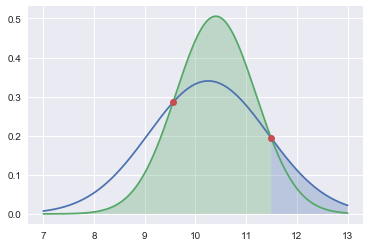

Area under curves  1.06184377931
companies announce a merger companies announce a merger
ACCURACY of phrase - companies announce a merger 87.92270531400966
x 0.6521739130434783 y 0.6956521739130435 t 0.861111111111111 ed 1.0 force 1.0
the rationale behind the decision the rationale behind the decision
ACCURACY of phrase - the rationale behind the decision 94.87483530961791
x 0.782608695652174 y 0.8260869565217391 t 0.9696969696969696 ed 1.0 force 1.0
thank you for your help thank you for your help
ACCURACY of phrase - thank you for your help 93.15789473684211
x 0.6842105263157895 y 0.631578947368421 t 1.0 ed 1.0 force 1.0
frequently asked questions frequently asked questions
ACCURACY of phrase - frequently asked questions 85.58333333333334
x 0.75 y 0.7083333333333334 t 0.775 ed 1.0 force 1.0
protect your envo protect your environment
ACCURACY of phrase - protect your envo 70.22222222222223
x 0.4 y 0.6 t 0.7555555555555556 ed 0.0 force 1.0
sent this by registered mail sent this by regis

In [2]:
if __name__ == "__main__":
    train_path = r"/Users/shruti6991/Desktop/Tap_typing_data/touch_data_training/"
    test_path = r"/Users/shruti6991/Desktop/Tap_typing_data/touch_data_testing/"
    train_sensor_path = r"/Users/shruti6991/Desktop/Tap_typing_data/sensor_data_training/"
    test_sensor_path = r"/Users/shruti6991/Desktop/Tap_typing_data/sensor_data_testing/"
    zipped = sorted(zip(sorted(glob.glob(os.path.join(train_path, '10.xml'))), sorted(glob.glob(os.path.join(test_path, '10.xml'))),
            sorted(glob.glob(os.path.join(train_sensor_path, '10.txt'))),sorted(glob.glob(os.path.join(test_sensor_path, '10.txt'))) ))
    for w,x,y,z in zipped:
        print(w,x,y,z)
        train(w,x,y,z)
        #print(w,x,y,z)
        test(w,x,y,z)
        print("success")
  